In [34]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import speclite
from astropy.io import fits
from astropy.table import Table, vstack
from skypy.pipeline import Pipeline
from slsim.Observations.roman_speclite import configure_roman_filters, filter_names
import pickle
from lenstronomy.Util import constants
from pprint import pprint
from tqdm import tqdm
import os
from glob import glob

matplotlib.rcParams['axes.grid'] = False
matplotlib.rcParams['image.origin'] = 'lower'
%matplotlib inline

`jupyter nbconvert --to python build_galaxy_cat_file.ipynb --TemplateExporter.exclude_markdown=True --TemplateExporter.exclude_output_prompt=True --TemplateExporter.exclude_input_prompt=True`

In [35]:
ra = 30
dec = -30

In [36]:
# compute detector side in decimal degrees
detector_side_arcsec = 4096 * 0.11
detector_side_deg = detector_side_arcsec / 3600
offset = detector_side_deg / 2

In [37]:
# load Roman WFI filters
configure_roman_filters()
roman_filters = filter_names()
roman_filters.sort()
_ = speclite.filters.load_filters(*roman_filters[:8])

In [38]:
# execute SkyPy galaxy photometry simulation pipeline
pipeline = Pipeline.read('roman_hlwas.yml')
pipeline.execute()

# print(pipeline.state)

In [39]:
skypy_galaxies = vstack([pipeline['blue'], pipeline['red']])
# np.save('skypy_galaxies.npy', skypy_galaxies)

# skypy_galaxies = np.load('skypy_galaxies.npy')
# skypy_galaxies.show_in_notebook(display_length=10)
skypy_galaxies.columns

<TableColumns names=('z','M','coeff','ellipticity','physical_size','stellar_mass','angular_size','mag_F062','mag_F087','mag_F106','mag_F129','mag_F158','mag_F184','mag_F146','mag_F213')>

In [40]:
# look at the distribution of galaxies in terms of angular size

# convert units to pixels

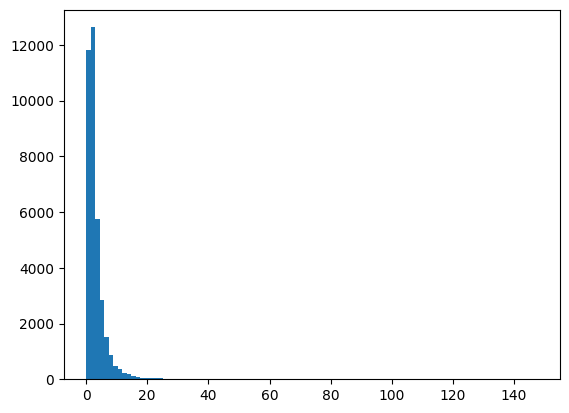

In [41]:
angular_sizes = skypy_galaxies['angular_size']
re = [a * 206265 / 0.11 for a in angular_sizes]

plt.hist(re, bins=100)
plt.show()

In [42]:
re[:10]

[1.1668896108119888,
 2.6124120360903,
 1.9694178912413598,
 3.6865388199760787,
 2.768053695821952,
 1.500495502141971,
 4.603717610974922,
 8.575400202040798,
 2.024959807091117,
 1.7969538582018918]

In [43]:
skypy_galaxies[:10]

z,M,coeff,ellipticity,physical_size,stellar_mass,angular_size,mag_F062,mag_F087,mag_F106,mag_F129,mag_F158,mag_F184,mag_F146,mag_F213
,,,,kpc,,rad,,,,,,,,
float64,float64,float64[5],float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1.8281297301753874,-16.60289782505482,0.0971456625823786 .. 0.026269759071963758,0.5633090510555495,1.1101359012258778,458970783.36281455,6.222958678850933e-07,29.55973967853327,29.20060943869943,28.57635766716521,27.958652586820058,27.765388337695207,27.506370518868607,27.92987169339309,27.53092510248407
4.3501305937376635,-20.39197753945026,0.24814259675332206 .. 0.19621517169262387,0.6017806703013168,1.970260578870098,10122624516.687605,1.3931850966956732e-06,28.19350568719628,27.77286891209023,27.50574746218677,27.303499323221644,26.916379361475848,26.65019654766678,27.080899310897934,26.059228197690935
2.137376534834953,-18.479081004366815,0.28671254230813437 .. 0.03657779050363205,0.2457027907471257,1.842482419215263,5961616846.38021,1.0502798246748096e-06,28.121603182998484,27.77376458568289,27.386735961118575,26.666591626324177,26.214653342369928,25.979985494840925,26.490689437808868,25.728179203321105
2.6143360989487516,-20.0515530903083,0.2594585036214728 .. 0.04973503872471033,0.09295910508839757,3.31765034205487,15951957613.77171,1.9660110546984155e-06,26.520362670017736,26.373310266359066,26.21009789054997,25.863153428000498,25.287478338515232,25.069103538812325,25.563824750860608,24.935158925334033
4.283004691489629,-18.006684110863155,0.27473426486110825 .. 0.052013555625553515,0.10349695524055909,2.1021111292341192,5275811838.102071,1.4761879453150788e-06,30.94017303822004,30.44919028651737,30.16615728508043,29.86408066248797,29.357790341105208,29.05203428672401,29.571737000027234,28.474200550084085
2.432457528740912,-17.92753374156059,0.07520766402960971 .. 0.04993526285772431,0.15419817673399563,1.372215973298008,2951564216.7676635,8.002060710038873e-07,28.417140269935423,28.279885745521817,28.076246286793875,27.671808777760802,27.174324316770424,26.988159377427152,27.44491459310187,26.774404479873027
4.259880589422469,-20.533691685335484,0.48646295224209246 .. 0.08140183429641798,0.3320361797288046,3.5044912045447028,25012635188.102386,2.4551375037318083e-06,28.317976393472172,27.8559112216168,27.547118526446013,27.30882479182452,26.847723685486073,26.51604231858242,27.024154551622196,25.86272184325049
3.968438242944938,-21.53456989693434,0.1929486738087046 .. 0.034282786345591926,0.6252532374292268,6.728041469718256,98972392167.61209,4.573214177027067e-06,25.848135157512893,25.72221945052643,25.60715494856489,25.550735649473957,25.338875536284327,25.035407437228166,25.37844207033168,24.574081472992923


In [44]:
from lenstronomy.Util import data_util

def roman_mag_to_cps(mag, band):
    if band == 'F106':
        mag_zero_point = 26.44
    elif band == 'F129':
        mag_zero_point = 26.40
    elif band == 'F184':
        mag_zero_point = 25.95
    else:
        raise ValueError('Unknown band')
    
    return data_util.magnitude2cps(mag, mag_zero_point)

In [45]:
galaxies = []
n_sersic_list = []

for gal in pipeline['blue']:
    n_sersic = np.random.normal(loc=1, scale=0.25, size=1)[0]
    n_sersic_list.append(n_sersic)
    galaxies.append(gal)

for gal in pipeline['red']:
    n_sersic = np.random.normal(loc=4, scale=1., size=1)[0]
    n_sersic_list.append(n_sersic)
    galaxies.append(gal)

In [46]:
output_rows = []
id = 0
re_list = []

for gal, n_sersic in tqdm(zip(galaxies, n_sersic_list), total=len(galaxies)):
    # build information that STIPS needs
    gal_dict = {}
    gal_dict['id'] = id
    gal_dict['ra'] = np.random.uniform(low=ra - offset, high=ra + offset, size=1)[0]  # ra + offset # center
    gal_dict['dec'] = np.random.uniform(low=dec - offset, high=dec + offset, size=1)[0]  # dec + offset # center
    gal_dict['F106'] = roman_mag_to_cps(mag=gal['mag_F106'], band='F106')
    gal_dict['F129'] = roman_mag_to_cps(mag=gal['mag_F129'], band='F129')
    gal_dict['F184'] = roman_mag_to_cps(mag=gal['mag_F184'], band='F184')
    gal_dict['type'] = 'sersic'
    gal_dict['n'] = n_sersic
    gal_dict['re'] = (gal['angular_size'] * 206265) / 0.11  # STIPS wants units of pixels
    gal_dict['phi'] = np.random.uniform(low=0, high=360, size=1)[0]
    gal_dict['ratio'] = np.random.normal(loc=0.8, scale=0.1, size=1)[0]
    gal_dict['notes'] = ''
    output_rows.append(gal_dict)
    id += 1

    re_list.append(gal_dict['re'])

100%|██████████| 37237/37237 [00:01<00:00, 20007.43it/s]


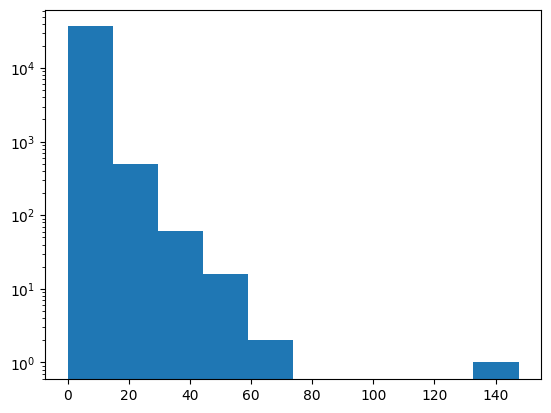

In [47]:
plt.hist(re_list)
plt.yscale('log')
plt.show()

In [48]:
sorted_rows = sorted(output_rows, key=lambda d: d['re'], reverse=True)

# filter out brightest galaxies
# rows_to_write = [row for row in sorted_rows if 1e2 < row['F106'] and row['F106'] < 1e3]

# limit
import random
rows_to_write = random.sample(sorted_rows, 25)
# rows_to_write = sorted_rows[:25]

In [49]:
# rows_to_write = output_rows[:10]

In [50]:
import pandas as pd

df = pd.DataFrame(rows_to_write)
df

,id,ra,dec,F106,F129,F184,type,n,re,phi,ratio,notes
0,7778,29.950085,-29.989200,0.459936,0.973727,1.651360,sersic,0.638173,6.831680,10.238247,0.763804,
1,5533,29.952690,-29.956769,0.356781,0.365541,0.317971,sersic,1.010896,3.176544,336.060064,0.731781,
2,744,30.055222,-30.024549,0.943770,1.054456,1.503969,sersic,0.856642,3.676590,135.147847,0.718508,
3,2780,30.003403,-29.962220,0.110420,0.137872,0.131836,sersic,1.265997,1.029323,258.284778,0.798527,
4,14859,30.036334,-30.029650,12.905207,14.537032,14.710917,sersic,1.340527,15.910713,3.401391,0.778363,
5,8696,29.965257,-29.954577,1.925341,2.331751,2.218568,sersic,1.082970,2.496766,291.445486,0.767904,
6,6253,29.971407,-29.950799,0.381260,0.421502,0.351449,sersic,1.038695,0.364636,314.350966,0.718230,
7,33765,29.966004,-30.029649,8.283446,10.246057,9.753163,sersic,0.899360,2.115163,60.645831,0.759477,
8,9983,29.976170,-30.043395,0.083911,0.085546,0.097133,sersic,0.820898,1.792826,324.003012,0.878846,
9,3571,30.028768,-30.010226,0.100769,0.163093,0.174434,sersic,0.985816,1.048112,236.928002,0.915859,


In [51]:
from astropy.table import Table

table = Table.from_pandas(df)

In [52]:
# write table to fits file
output_file = '/data/bwedig/STIPS/hlwas_sim_gals_000.fits'
table.write(output_file, format='fits', overwrite=True)

# set type header so STIPS knows how to interpret it
with fits.open(output_file, mode='update') as hdul:
    hdr = hdul[1].header
    hdr['TYPE'] = 'multifilter'

In [53]:
# # clear out old files
# output_dir = os.path.join('/data/bwedig/STIPS')
# for f in glob(os.path.join(output_dir, '*')):
#     os.remove(f)

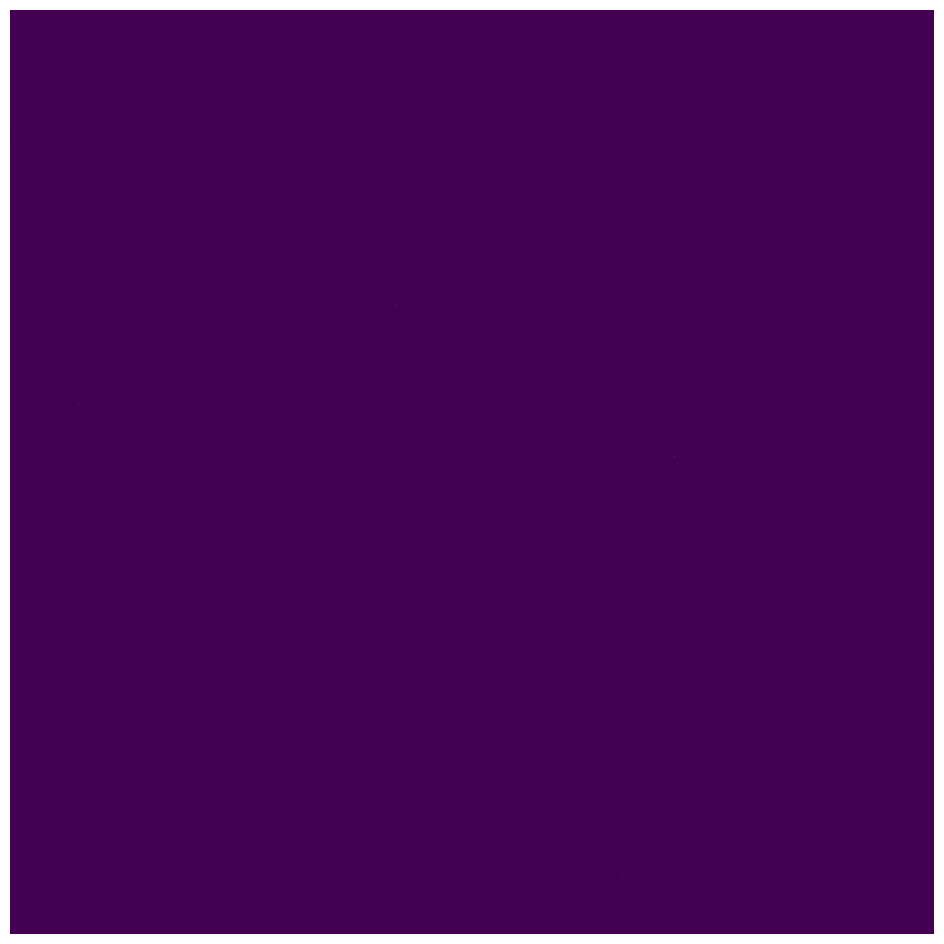

In [54]:
data_dir = os.path.join('/data/bwedig/STIPS')
images_f106 = [np.load(f) for f in sorted(glob(os.path.join(data_dir, 'hlwas_sim_F106_*.npy')))]

plt.figure(figsize=(12, 12))
plt.imshow(images_f106[0])
plt.axis('off')
plt.show()